In [1]:
# Import Data Preprocessing and Wrangling libraries
import re
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from datetime import datetime
import dateutil.parser


# Import Visualization Libraries
import plotly.offline as pyo
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
import scattertext as st
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

In [ ]:
df = pd.read_csv('elon_musk_tweets.csv')

In [ ]:
data = df.copy()
data['original_tweet'] = df['text']
data['datetime'] = data['date']
data['datetime'] = data.datetime.apply(lambda x: dateutil.parser.parse(x))
rt_mask = data.text.apply(lambda x: "RT @" in x)

# standard tweet preprocessing
data.text = data.text.str.lower()
#Remove twitter handlers
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x))
#remove hashtags
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x))
# Remove URLS
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x))
# Remove all the special characters
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))
#remove all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Substituting multiple spaces with single space
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

# convert the 'date' column to datetime format and remove the timezone information
data['datetime'] = pd.to_datetime(data['datetime']).dt.tz_localize(None)


# Viewing the preprocessed data
data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,original_tweet,datetime
0,1544379368478212100,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240855,115,13503,True,2022-07-05 17:55:09+00:00,i find the gold toe sock inevitably off kilter...,NaN,Twitter for iPhone,335,6542,False,@BillyM2k I find the gold toe sock – inevitabl...,2022-07-05 17:55:09
1,1544377493263720450,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:47:42+00:00,sock con the conference for socks,NaN,Twitter for iPhone,1451,30753,False,"Sock Con, the conference for socks",2022-07-05 17:47:42
2,1544377130590552064,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:46:15+00:00,always something new for the magazine cover an...,NaN,Twitter for iPhone,1284,28610,False,Always something new for the magazine cover an...,2022-07-05 17:46:15
3,1544375575724400645,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:40:05+00:00,this guy gets it,NaN,Twitter for iPhone,131,3640,False,@ExplainThisBob This guy gets it,2022-07-05 17:40:05
4,1544375148605853699,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:38:23+00:00,sock tech is so advanced that you can get pret...,NaN,Twitter for iPhone,1191,23790,False,Sock tech is so advanced that you can get pret...,2022-07-05 17:38:23


In [ ]:
text = data['text'][11]
inputs = tokenizer(text, return_tensors="pt")

In [ ]:
outputs = model(**inputs)
predictions = outputs.logits

In [ ]:
from torch.nn.functional import softmax
import torch

In [ ]:
probabilities = softmax(predictions, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

In [ ]:
predicted_class

0

In [ ]:
result = []

# Duyệt qua từng dòng trong DataFrame và thực hiện dự đoán
for index, row in df.iterrows():
    text = row['text']

    # Tokenization
    inputs = tokenizer(text, return_tensors="pt")

    # Dự đoán
    outputs = model(**inputs)
    logits = outputs.logits

    # Chuyển đổi thành xác suất
    probabilities = softmax(logits, dim=1)

    # Lấy lớp có xác suất cao nhất
    predicted_class = torch.argmax(probabilities, dim=1).item()

    # Thêm kết quả vào DataFrame mới
    result.append({
        'text': text,
        'predicted_class': predicted_class,
        'probability': probabilities[0, predicted_class].item()
    })

result_df = pd.DataFrame(result)
# In ra kết quả
print(result_df)

                                                   text  predicted_class  \
0     @BillyM2k I find the gold toe sock – inevitabl...                0   
1                    Sock Con, the conference for socks                1   
2     Always something new for the magazine cover an...                1   
3                      @ExplainThisBob This guy gets it                1   
4     Sock tech is so advanced that you can get pret...                2   
...                                                 ...              ...   
5899                     @JonErlichman He’s not wrong …                1   
5900  @alifarhat79 Guys, I think I maybe took too mu...                0   
5901                                      @sriramk Cool                1   
5902               @cb_doge Time to complete the circle                1   
5903         @Jason Late stage civilization complacency                1   

      probability  
0        0.848258  
1        0.828354  
2        0.555510  
3      

In [2]:
df = pd.read_csv('archive/result.csv')

In [3]:
df.head()

,text,predicted_class,probability
0,@BillyM2k I find the gold toe sock – inevitabl...,0,0.848258
1,"Sock Con, the conference for socks",1,0.828354
2,Always something new for the magazine cover an...,1,0.555510
3,@ExplainThisBob This guy gets it,1,0.616596
4,Sock tech is so advanced that you can get pret...,2,0.914286


In [7]:
df.to_csv('result.csv', index=False)

In [8]:
df['predicted_class'] = df['predicted_class'].replace({0: 'negative', 1: 'neutral', 2: 'positive'})

In [9]:
import plotly.offline as pyo
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

In [10]:
title = 'Sentiment Distribution roBERTa'
sentiment_pie = pd.DataFrame(df['predicted_class'].value_counts() / df.shape[0]*100).reset_index()
sentiment_pie.columns = ['Sentiment', 'Percentage']
fig = px.pie(sentiment_pie, values='Percentage', names='Sentiment')

fig.update_traces(marker=dict(colors=['#00adb5', '#f8b195', '#f67280']), textposition='inside')
fig.update_layout(
    title_text=title,
    title_x=0.48,
    template='plotly_dark',
    font=dict(
        family='Arial',
        size=20,  # Increase label font size to 20
        color='white'
    ),
    height=700,
    legend=dict(
        title='',
        orientation='h',
        yanchor='bottom',
        y=-0.15,
        xanchor='center',
        x=0.5,
        font=dict(
            family='Arial',
            size=12,
            color='white'
        )
    )
)
fig.write_image('Sentiment Distribution.png')
fig.show()


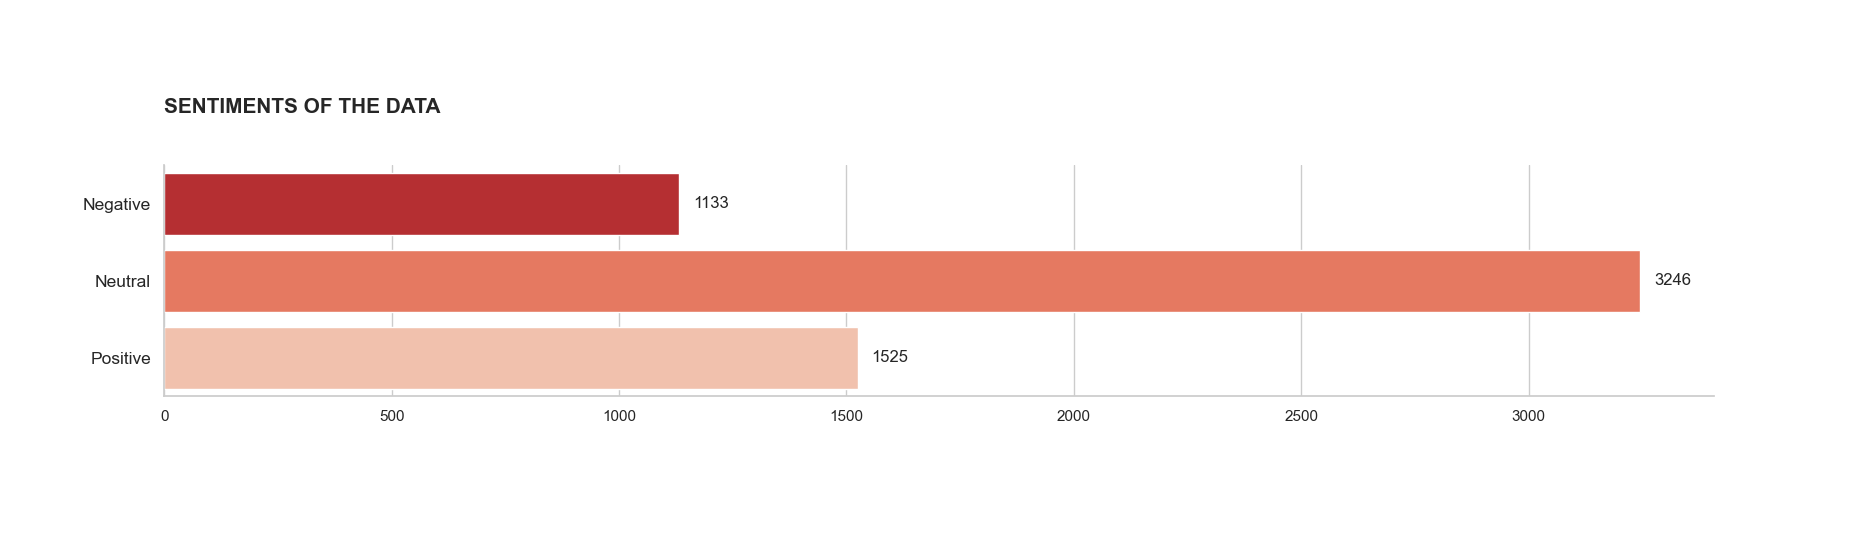

In [11]:
def plot_countplot(data=None, x=None, y=None, palette='Reds_r', height=15, title=' ', subtitle=' ', description=' '):
    sns.set(style = 'whitegrid',
            rc = {'figure.figsize': (20,height)})

    g = sns.countplot(data=data, y=y, x=x, palette=palette)

    g.set_ylabel(' \n\n\n')
    g.set_xlabel(' \n\n\n\n\n')

    g.set_title(
        f'\n\n\n\n{title}\n\n'.upper(),
        loc = 'left',
        fontdict = dict(
            fontsize = 15,
            fontweight = 'bold'))

    g.set_yticklabels(
        [tick_label.get_text().title() for tick_label in g.get_yticklabels()],
        fontdict = dict(
            fontsize = 12.5,
            fontweight = 'medium'))

    plt.text(s = f'{subtitle}',
             alpha = 0.5,
             x = 0,
             y = 1.12,
             horizontalalignment = 'left',
             transform = g.transAxes)

    plt.text(s = f'{description}',
             alpha = 0.5,
             x = 0,
             y = -.18,
             verticalalignment = 'baseline',
             horizontalalignment = 'left',
             transform = g.transAxes)

    g.bar_label(container = g.containers[0], padding = 10,)

    plt.text(s = ' ', x = 1.08, y = 1, transform = g.transAxes)

    sns.despine()
    plt.savefig('countplot roBERTa.png')
    return g

plot_countplot(y = df['predicted_class'],
               title = 'Sentiments of the data',
               height = 3);